In [ ]:
from IPython.display import display_html
display_html("""
<div style="text-align:center; margin: 20px 0;">
<p style="color:#FA5882;text-align:center; margin: 10px 0 20px 0;">

</p>
<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">PE-TTM PB-TTM因子双因子分析</button>
<hr/>
</div>
""", raw=True)

In [2]:
import sys
import os
from collections import OrderedDict
import pandas as pd
import numpy as np
import pyfolio as pf
from pyfolio import plotting
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns
from matplotlib.ticker import FuncFormatter

project_path = os.path.abspath(os.path.dirname(os.getcwd())+os.path.sep+".")
sys.path.append(project_path)
from FactorAnalyse import FactorAnalyserBase
from DataPreProcessing import *

figsize=(20, 9)

D:\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


# 定义策略

这是一个简单的demo策略。
#### 去掉以下条件的股票：
1. PE-TTM<=0
2. PB-TTM<=0
3. ST股票
4. 上市天数<=365
5. 停牌的
6. PE-TTM、PB-TTM、ST、上市天数这几个字段无数据的股票。虽然代码中未明确写出要这样筛选，但代码的逻辑是有数据的才会选进来。


#### 股票打分策略：
1. 采用中位数去极值法和Z-Score法对1/PE-TTM和1/PB-TTM进行处理
2. score = 0.8 * 1/PE-TTM + 0.2 * 1/PB-TTM


#### 因子中性化 NeutralizeMethod.Method_Residual(score, df)
这个和股票组合的中性化不同。这里实际把待测因子score与df中的已知风险因子进行正交化处理，便于观察剔除已知因子影响后的效果。  
比如我们把行业因子和对数流通市值因子作为已知因子，对score进行中性化，函数调用这样写NeutralizeMethod.Method_Residual(score, df[['对数流通市值', '申万一级行业']])。函数里面进行以下截面回归。
$$ score = \beta_1 \ln LMV + \sum_{i=1}^{n}{\beta_{2,i}\times SWInd_i} + \epsilon$$
其中$\ln LMV$就是对数流通市值因子，$SWInd_i$是申万一级行业哑变量，$\epsilon$是中性化后的因子

另外注意调用顺序，一般是先后去极值、标准化、中性化

In [3]:
class PETTM_PBTTM_Strategy(FactorAnalyserBase):
    def __init__(self, start_date, end_date, benchmark_id, universe, factor_list, props):
        super(PETTM_PBTTM_Strategy, self).__init__(start_date, end_date, benchmark_id,
                                                        universe, factor_list, props)

    def filter(self):
        for date, df in self.raw_universe_df_dict.items():
            self.set_filter((df['PE-TTM'] > 0) & (df['PB-TTM'] > 0) & (~df['ST']) & (df['上市天数'] > 365) & (~df['停牌']), date) 

    def rate_stock(self):
        """
        选股逻辑，去极值、中性化、标准化等。需要用户自己定义
        """
        for date, df in self.processed_universe_df_dict.items():
            df['PE-TTM'] = StandardizeMethod.Method_Z_Score(DeExtremeMethod.Method_Median(1/df['PE-TTM']))
            df['PB-TTM'] = StandardizeMethod.Method_Z_Score(DeExtremeMethod.Method_Median(1/df['PB-TTM']))            
            
            score = 0.8 * df['PE-TTM'] + 0.2 * df['PB-TTM']
            # 中性化
#             df['对数流通市值'] = StandardizeMethod.Method_Z_Score(DeExtremeMethod.Method_Median(np.log(df['流通市值'])))
#             score = NeutralizeMethod.Method_Residual(score, df[['对数流通市值', '申万一级行业']])
            
            self.set_score(score, date)

# 回测

#### PETTM_PBTTM_Strategy类benchmark参数
1. 可选'399905.SZ'，'000300.SH', '000016.SH',以及各申万一级行业指数代码，今后如果需要可以支持二级行业指数，或者是中信行业指数。  

#### PETTM_PBTTM_Strategy类universe参数
1. 可选'全A'、'沪深300'、'中证500'、'上证50'、'创业板'，'中证800'  

#### PETTM_PBTTM_Strategy类props参数：
1. 不另行设置时默认值为：props = {'单边交易费率': 0.0015, '换仓日期模式': '月初换', '自定义换仓日期': None, '自定义篮子': None}  
2. 换仓日期模式可选 月初换，月末换和自定义
3. 当换仓日期模式选择了自定义，需要同时向自定义换仓日期传入换仓日期list
4. 自定义篮子尚不支持，占坑。  

#### grouping_test方法介绍

分组收益分析，基于Score分组，由大到小分别是Q1、Q2...Q group_num，快速回测  
        :param group_num: 分组数量  
        :param control_dict: 需要控制的因子，若不为空必须是OrderDict，需要控制的因子名称为key，分组数量为value，
                              非数字型因子，如行业分类，则value为空字符串 ： ""。将按顺序依次控制分组。
                              例如：OrderedDict([('申万一级行业', ''), ('流通市值', 3)])  
        :param group_by_benchmark: 是否按基准的因子去划分  
        :param weight_method:配权方法，目前只支持EW、LVW和VW，分别是等权、流通市值平方根加权，总市值平方根加权  
        :param max_stock_num 每个分组网格内最大的持股数  
        :return: result_dict:包含4个部分。分组回测的净值、分组回测每个持有周期的IC、分组回测每次的换手率、
                                            控制变量下每组的股票数量。  

In [4]:
fab = PETTM_PBTTM_Strategy(pd.to_datetime('2017-01-01'), pd.to_datetime('2018-12-31'), '沪深300', '沪深300',
                             ['PE-TTM', 'PB-TTM'], {})
fab.prepare_data()
fab.filter()
fab.rate_stock()
result = fab.grouping_test(5, OrderedDict([('申万一级行业', ''), ('流通市值', 5)]),
                           group_by_benchmark=True, weight_method='VW')
# result = fab.grouping_test(10, {}, weight_method='VW')

# 分析结果

## 分组净值


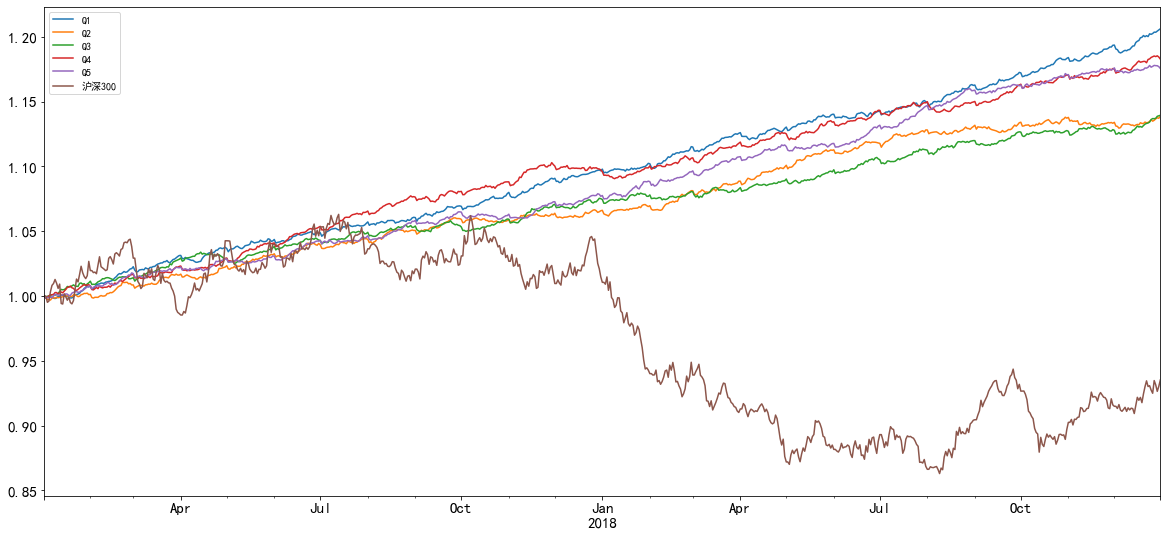

In [5]:
nav_df = (1+result.all_group_ret_df).cumprod()
nav_df[result.group_list+[result.benchmark_id]].plot(figsize=figsize,fontsize=15)

## 分组累计超额

整个回测区间的累积超额收益率

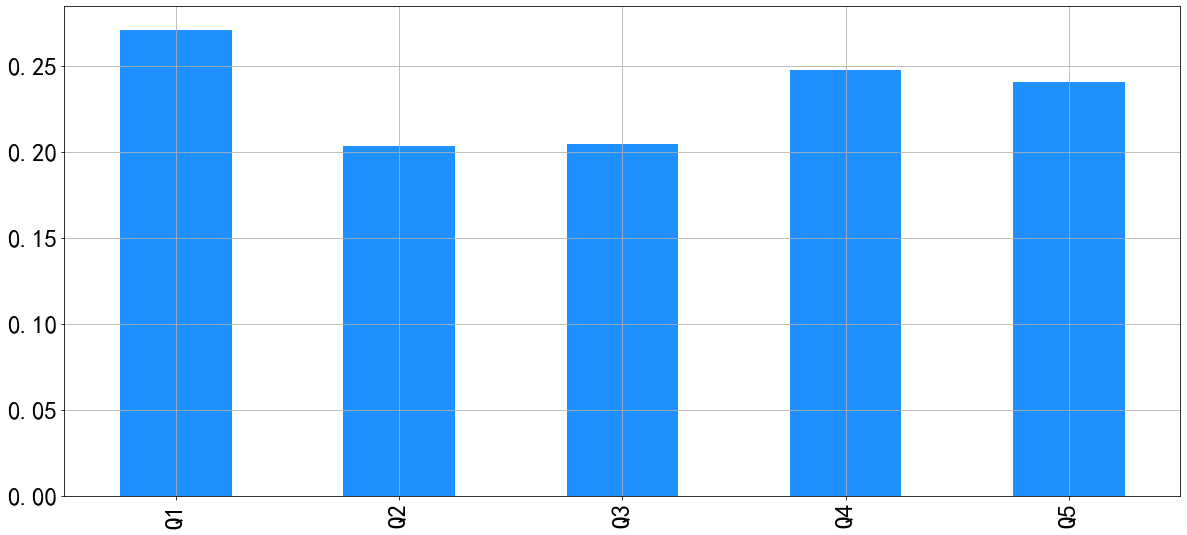

In [6]:
excess_df = nav_df.iloc[-1,:-1] - nav_df.iloc[-1,-1]
excess_df[result.group_list].plot(kind='bar', figsize=figsize,fontsize=25, color='dodgerblue',grid=True)

## 多空组合净值

Text(0.5, 1.0, '多空组合净值')

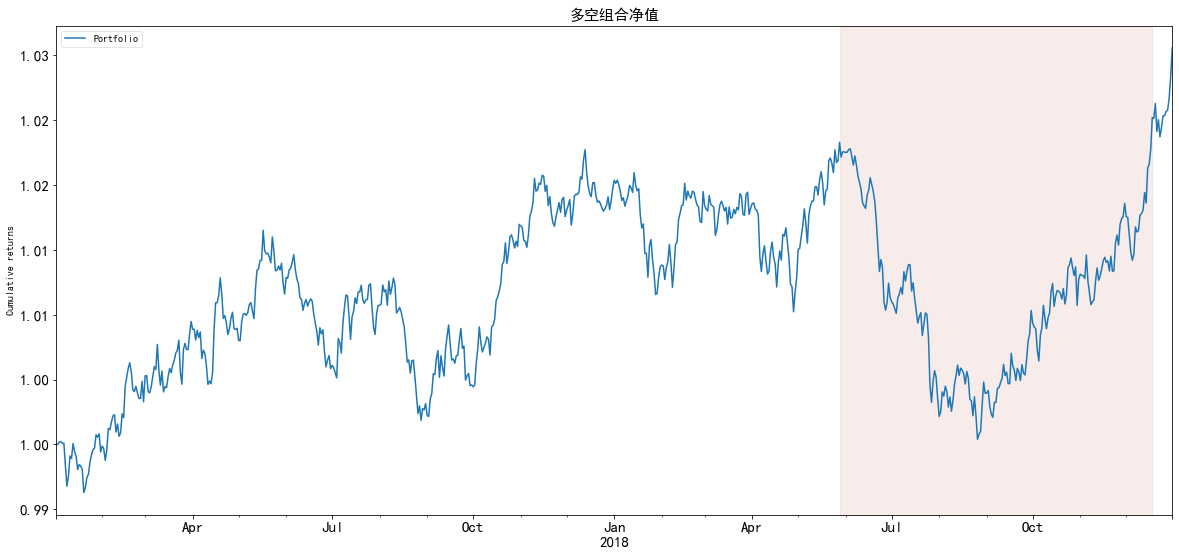

In [7]:
nav = nav_df[result.group_list[0]] - nav_df[result.group_list[-1]] + 1

plt.figure(figsize=figsize)
plotting.plot_drawdown_periods(
        nav.pct_change(), top=1, fontsize=15)
plt.title('多空组合净值',fontsize=15)

## 指数减空头

Text(0.5, 1.0, '指数减空头')

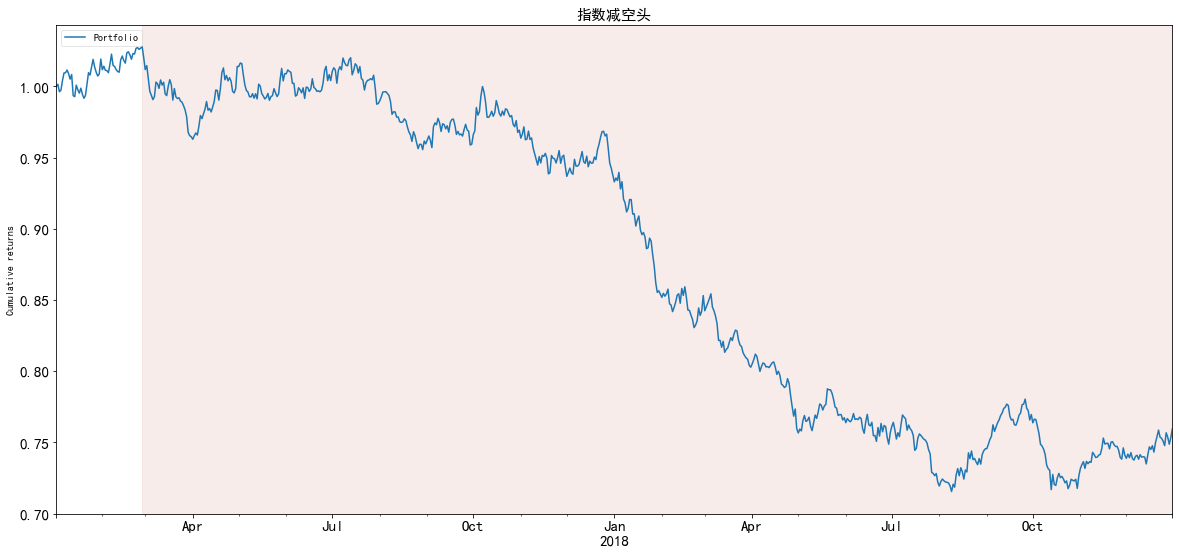

In [8]:
nav = nav_df[result.benchmark_id] - nav_df[result.group_list[-1]] + 1

plt.figure(figsize=figsize)
plotting.plot_drawdown_periods(
        nav.pct_change(), top=1, fontsize=15)
plt.title('指数减空头',fontsize=15)

## 多头减指数

Text(0.5, 1.0, '多头减指数')

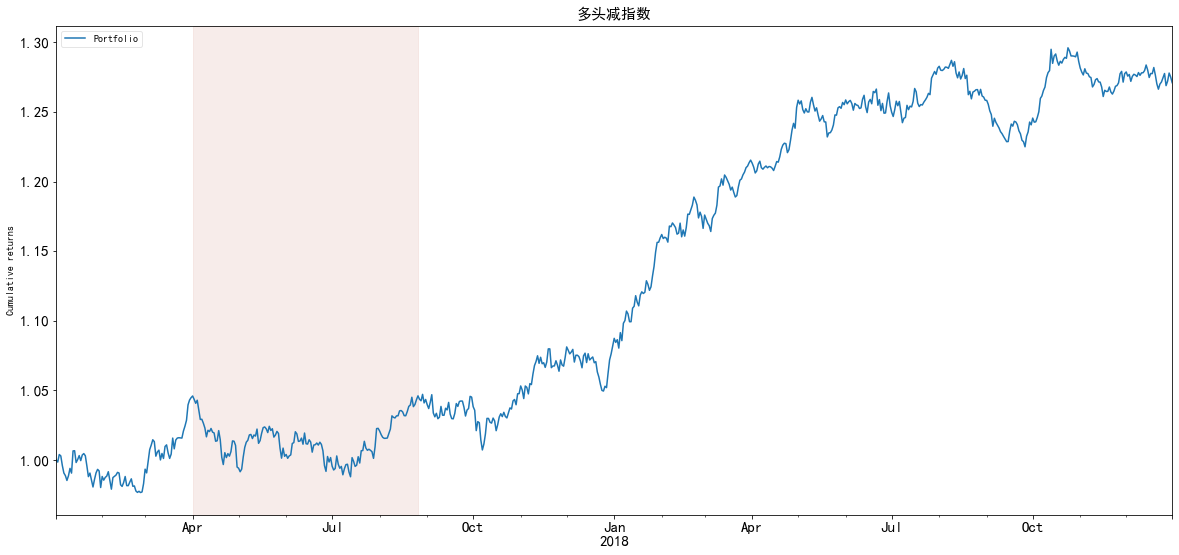

In [9]:
nav = nav_df[result.group_list[0]] - nav_df[result.benchmark_id] + 1

plt.figure(figsize=figsize)
plotting.plot_drawdown_periods(
        nav.pct_change(), top=1, fontsize=15)
plt.title('多头减指数',fontsize=15)

## 年度统计

以下分析都是针对Q1组合的。  
注1：年化因子为365天，与wind一致。  
注2：超额收益即 Rp - Rb  
注3：alpha 和 beta 是根据CAMP公式将Rp-Rf与Rb-Rf进行回归得出的系数。因此alpha相比超额收益来说多了风险调整这一步。  

In [10]:
annual_ra_df = result.get_annual_return_statistic()
styles = [
            dict(selector="caption", props=[("font-size", "150%"),
                                            ("text-align", "center")]),
            dict(selector="caption", props=[("caption-side", "bottom")]),
            dict(selector="th", props=[("max-width", "1200px"),
                                       ("text-align", "center")])]
pct_fields = []
float_fields = []
for col in annual_ra_df:
    if '%' in col:
        pct_fields.append(col)
    else:
        float_fields.append(col)
annual_ra_df.style.format("{:.2%}", subset=pct_fields) \
            .format("{:.2}", subset=float_fields) \
            .set_properties(**{'max-width': '1000px', 'font-size': '11pt'}) \
            .set_caption("净值评价") \
            .set_table_styles(styles) \
            .bar(align='mid', color=['#5fba7d', '#d65f5f'])

,累计收益(%),年化收益(%),最大回撤(%),年化超额收益(%),超额最大回撤(%),年化alpha(%),Beta,跟踪误差(%),信息比率,Sharpe比率,超额Sharpe比率,Calmar比率,超额Calmar比率
2017,9.67%,9.72%,-0.52%,7.17%,-5.77%,6.47%,-0.0027,0.50%,0.04,3.9,2.7,1.9e+01,1.2
2018,9.99%,10.02%,-0.51%,18.32%,-7.17%,6.84%,0.0066,0.50%,0.094,4.0,8.8,2e+01,2.6
全区间,20.62%,9.86%,-0.52%,12.60%,-7.17%,6.62%,0.002,0.50%,0.067,4.0,5.8,1.9e+01,1.8


## 纯多月收益统计

以下分析都是针对Q1组合的。

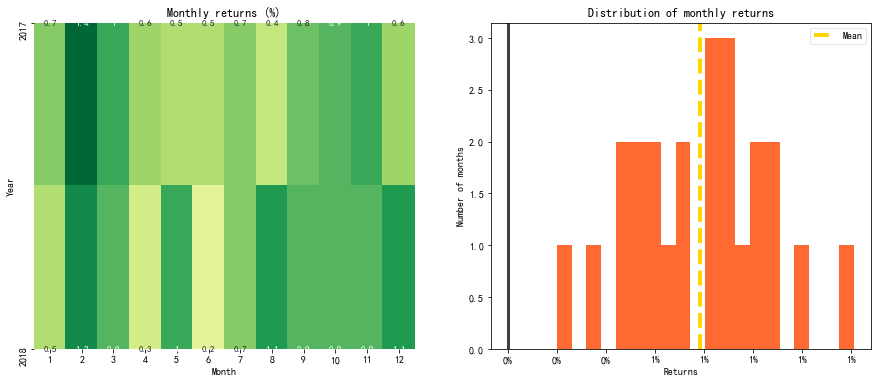

In [11]:
plt.figure(figsize=(15,6))
ax_monthly_heatmap = plt.subplot(121)
ax_monthly_dist = plt.subplot(122)
plotting.plot_monthly_returns_heatmap(result.ret_df['p'], ax=ax_monthly_heatmap)
plotting.plot_monthly_returns_dist(result.ret_df['p'], ax=ax_monthly_dist)

## 超额月收益统计

以下分析都是针对Q1组合的。

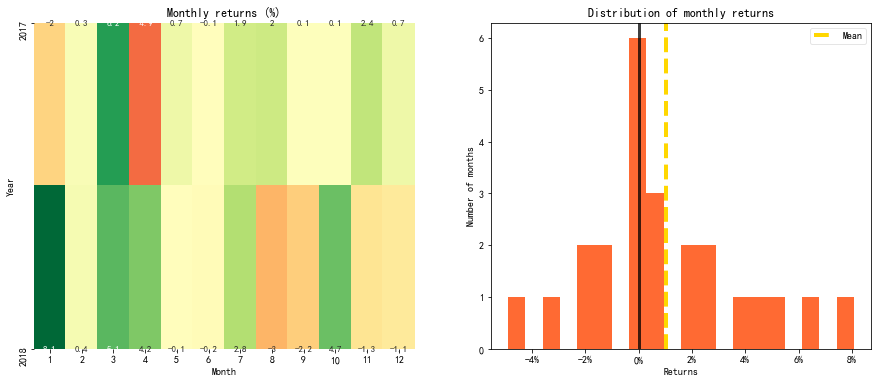

In [12]:
plt.figure(figsize=(15,6))
ax_monthly_heatmap = plt.subplot(121)
ax_monthly_dist = plt.subplot(122)
plotting.plot_monthly_returns_heatmap(result.ret_df['excess'], ax=ax_monthly_heatmap)
plotting.plot_monthly_returns_dist(result.ret_df['excess'], ax=ax_monthly_dist)

## 持有期IC

IC分析不仅针对Q1，下图中每个柱子是直接对universe里面的所有股票的score与该持有期内的累计收益率作秩相关系数。  
如果回测中设定了“换仓日期模式”为 “月初换”或“月末换”，那么持有期就是一个自然月。而如果“换仓日期模式”是“自定义”，那持有期就是自定义日期序列里两个相邻日期之间的时间段。

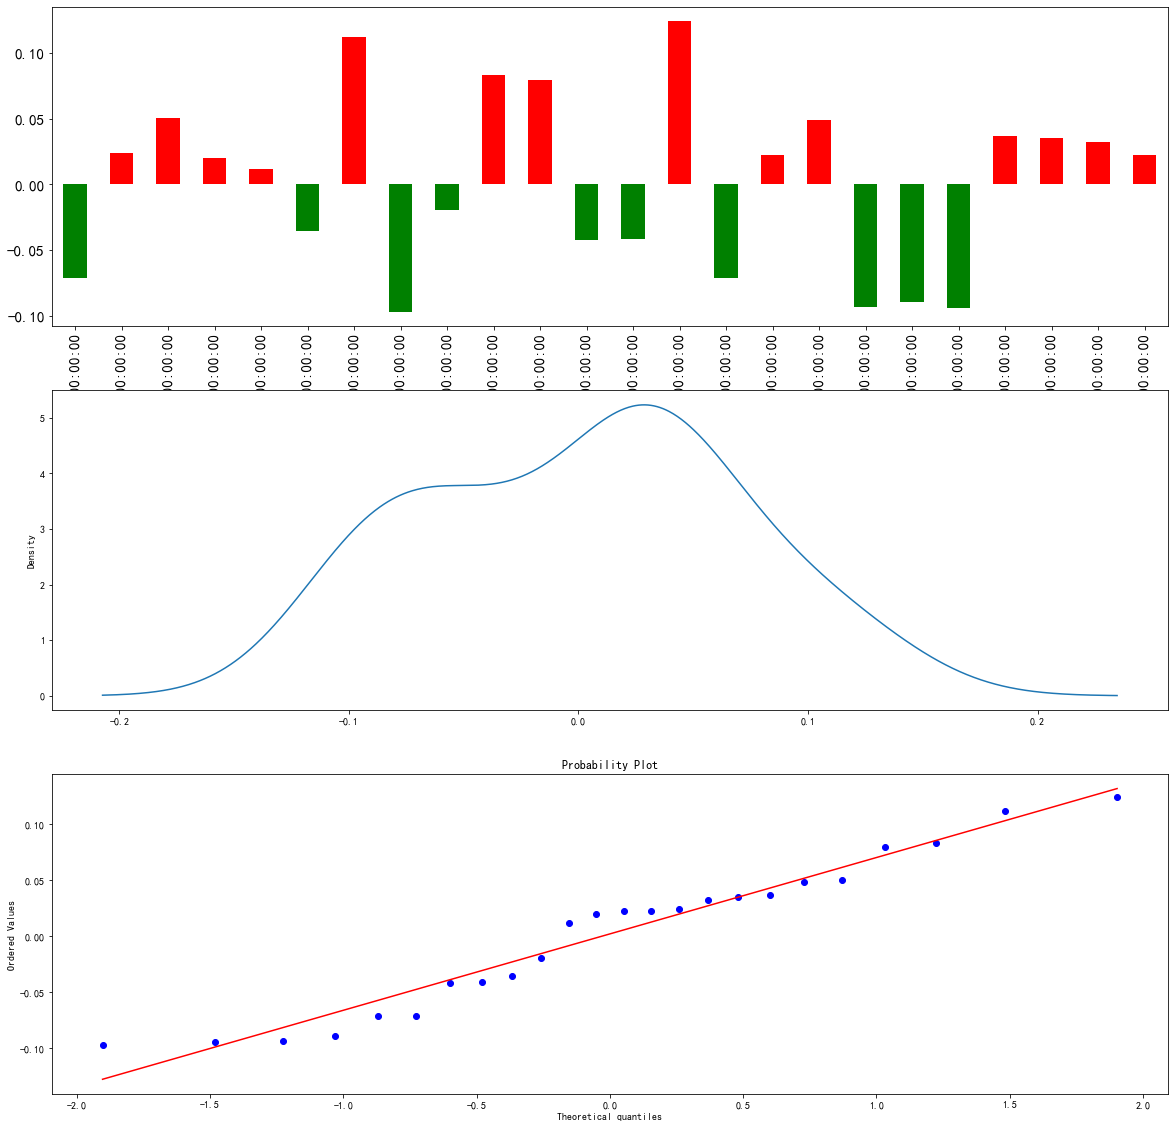

In [13]:
from scipy import stats
ic_plus = result.ic_series.copy()
ic_plus[result.ic_series<0] = np.nan
ic_minus = result.ic_series.copy()
ic_minus[result.ic_series>=0] = np.nan

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(311)
ic_plus.plot(kind='bar', color='r',ax=ax1, fontsize=15)
ic_minus.plot(kind='bar', color='g',ax=ax1, fontsize=15)

ax2 = fig.add_subplot(312)
result.ic_series.plot(kind='kde', ax=ax2)

fig.add_subplot(313)
a=stats.probplot(result.ic_series, dist="norm", plot=plt)

## IC随持有天数变化

Text(0, 0.5, 'IC')

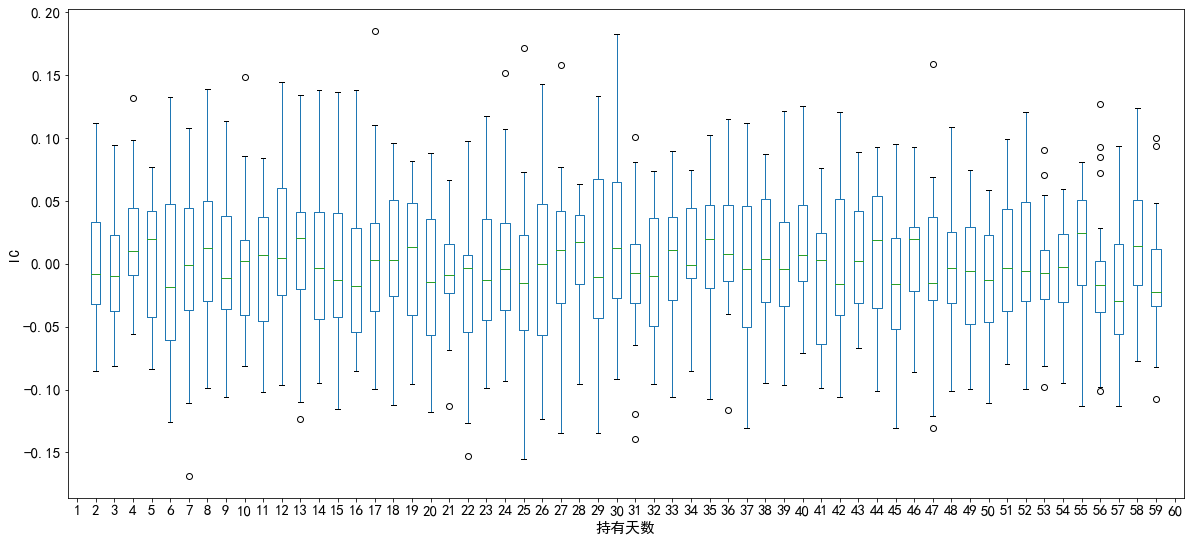

In [14]:
result.daily_ic_df.plot(kind='box', figsize=figsize, fontsize=15)
plt.xlabel('持有天数', fontsize=15)
plt.ylabel('IC', fontsize=15)

## IC 半衰期

半衰期通过下式回归得出
$$ y = a \times e^{-bx} $$
其中x是持续天数，y是T+x天后的当日收益率。
$$半衰期 = \frac{\ln2}{a}$$

Text(0, 0.5, 'IC半衰期')

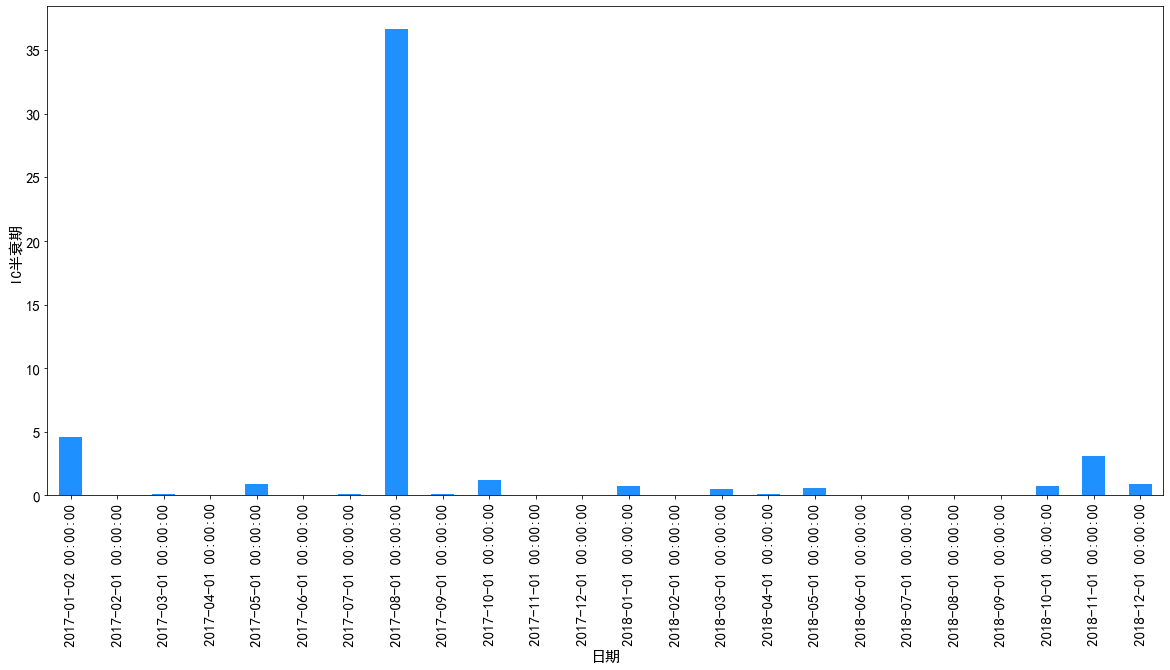

In [15]:
result.half_time_period_series.plot(kind='bar', figsize=figsize, fontsize=15, color='dodgerblue')
plt.xlabel('日期', fontsize=15)
plt.ylabel('IC半衰期', fontsize=15)

## 回归分析

每个持有期内，对全universe的期初score与当期收益率作回归，但这里还考虑了行业影响，加入了行业哑变量，如下：
$$ R = \alpha + \beta_1 score + \sum_{i=1}^{n}{\beta_{2,i}\times SWInd_i} + \epsilon$$
其中SWInd_i是行业哑变量。

,score_系数,score_t值,score_p值,R-squared,R-squared_Adj,F值
count,24.000000,24.000000,24.000000,2.400000e+01,24.000000,24.000000
mean,0.000268,0.103445,0.502789,2.929117e-03,-0.000417,0.877997
std,0.002574,0.951317,0.315939,2.974659e-03,0.002985,0.893895
min,-0.004915,-1.819243,0.069878,2.040320e-08,-0.003356,0.000006
25%,-0.000984,-0.351187,0.210021,1.589939e-04,-0.003196,0.047388
50%,0.000410,0.148649,0.415231,2.286047e-03,-0.001062,0.682896
75%,0.002510,0.941606,0.828646,5.278808e-03,0.001941,1.581462
max,0.003829,1.454435,0.998034,1.098420e-02,0.007665,3.309646


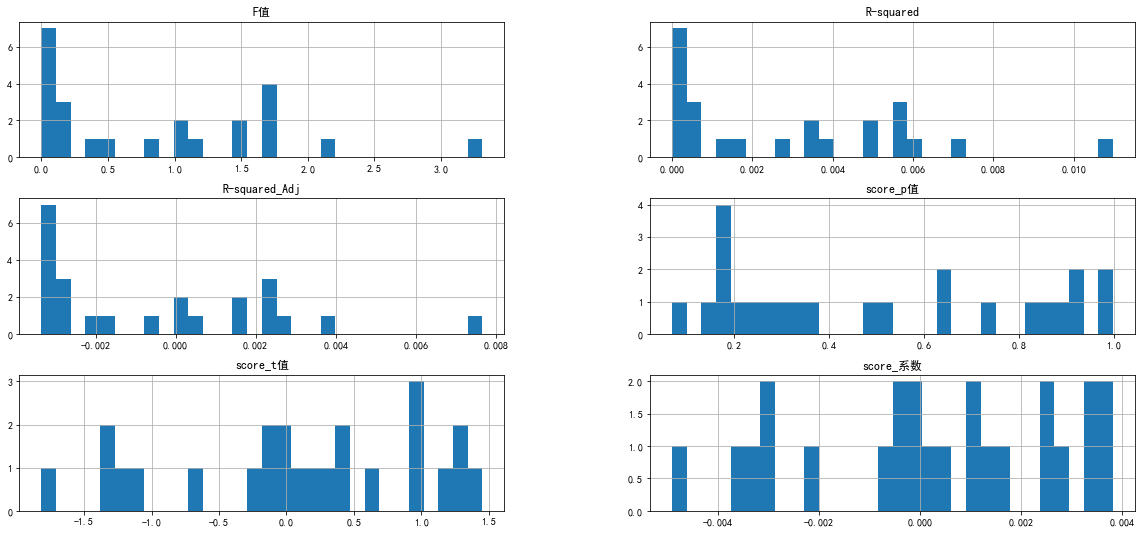

In [16]:
result.regression_result_df.astype(float).hist(bins=30, figsize=figsize)
result.regression_result_df.astype(float).describe()

## 行业超额收益率（中位数）

各行业在每个持有期内超额收益的中位数

(array([0.    , 0.0002, 0.0004, 0.0006, 0.0008, 0.001 , 0.0012, 0.0014,
        0.0016]), <a list of 9 Text yticklabel objects>)

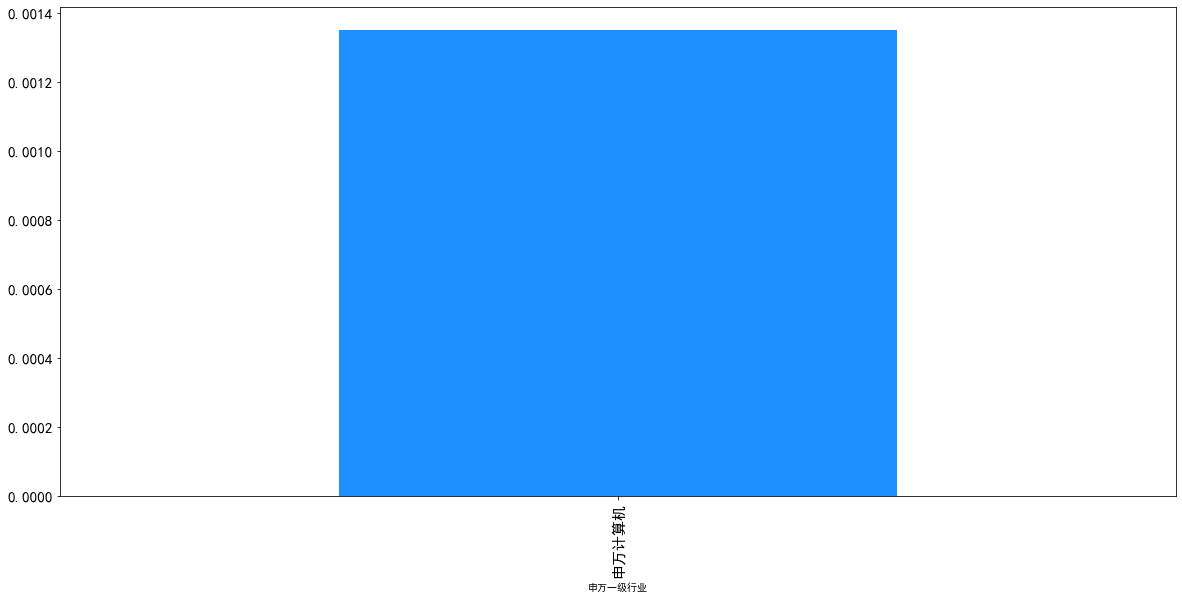

In [17]:
result.industry_alpha_df.median(axis=1).sort_values(ascending=False).plot(kind='bar',color='dodgerblue', figsize=figsize)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## 持仓换手率

,Q1,Q2,Q3,Q4,Q5
count,23.000000,23.000000,23.000000,23.000000,23.000000
mean,0.840361,0.837224,0.852000,0.841335,0.841915
std,0.042330,0.043417,0.031241,0.041701,0.037141
min,0.732493,0.733363,0.777680,0.759700,0.750901
25%,0.808789,0.801155,0.837897,0.817717,0.819534
50%,0.841207,0.833769,0.860753,0.838955,0.845249
75%,0.875464,0.864025,0.870986,0.874309,0.864737
max,0.899152,0.912350,0.901190,0.905785,0.923109


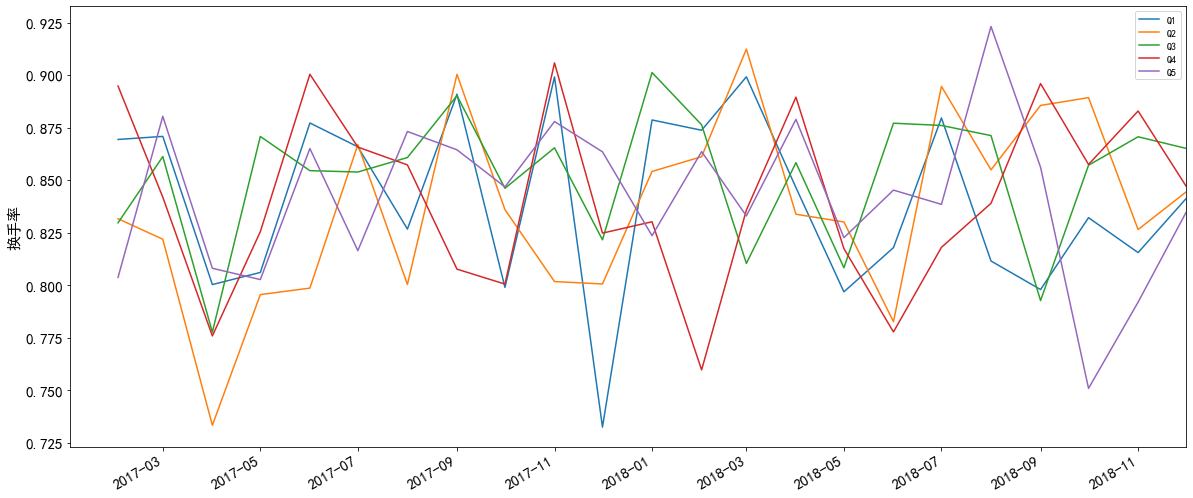

In [18]:
result.turnover_rate_df[result.group_list].plot(figsize=figsize, fontsize=15)
plt.ylabel('换手率', fontsize=15)
result.turnover_rate_df[result.group_list].astype(float).describe()

## 各分组内的可选股票数量

In [19]:
result.result_count_series_dict[max(result.result_count_series_dict.keys())]

数量
group_申万一级行业 group_流通市值                              grouping    
申万计算机        (6526233.500257495, 217870507.65440363] Q1        12
                                                     Q2        12
                                                     Q3        11
                                                     Q4        12
                                                     Q5        12
             (217870507.65440363, 443623497.5220978] Q1        13
                                                     Q2        13
                                                     Q3        12
                                                     Q4        13
                                                     Q5        13
             (443623497.5220978, 642589876.9801189]  Q1        12
                                                     Q2        12
                                                     Q3        11
                                                     Q4        12
                                                     Q5        12
             (642589876.9801189, 805454345.897059]   Q1        13
                                                     Q2        13
                                                     Q3        13
                                                     Q4        13
                                                     Q5        14
             (805454345.897059, 998495040.01398]     Q1        11
                                                     Q2        10
                                                     Q3        10
                                                     Q4        10
                                                     Q5        11

## score分布

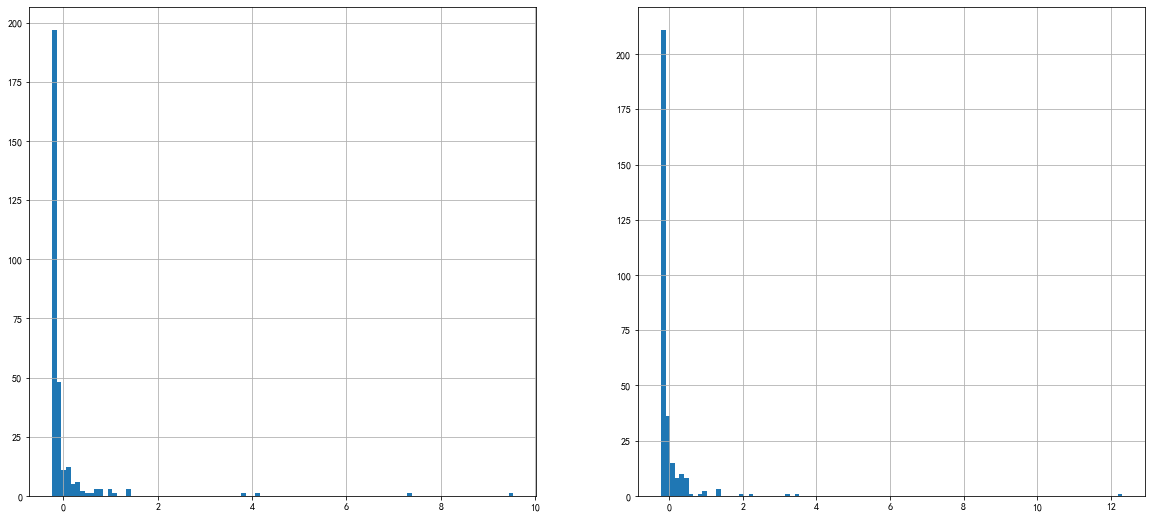

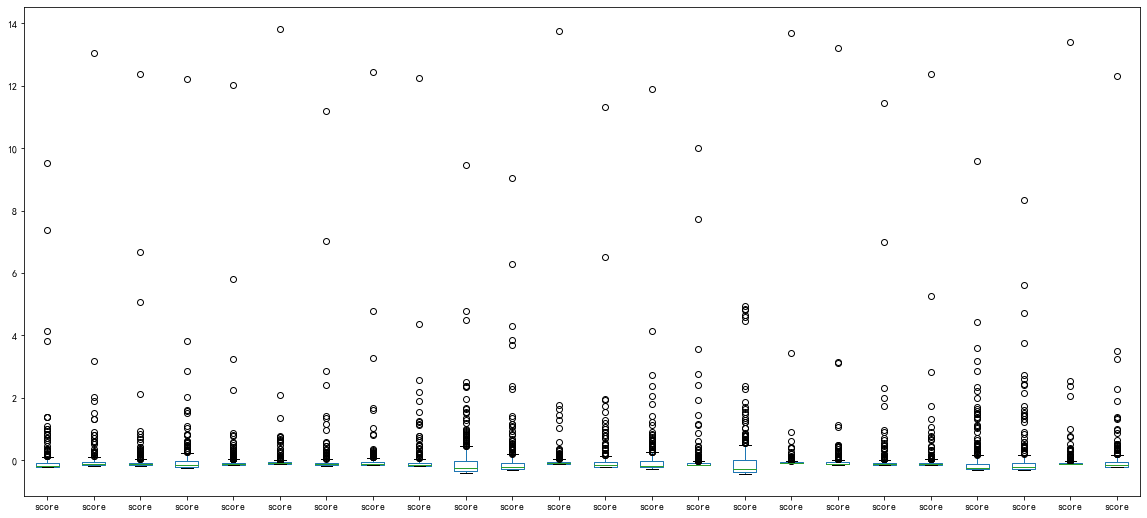

In [20]:
fig=plt.figure(figsize=figsize)
# 第一期
fig.add_subplot(121)
fab.processed_universe_df_dict[min(fab.processed_universe_df_dict.keys())]['score'].hist(bins=100)
# 最后一期
fig.add_subplot(122)
fab.processed_universe_df_dict[max(fab.processed_universe_df_dict.keys())]['score'].hist(bins=100)

l = []
for date,df in fab.processed_universe_df_dict.items():
    l.append(df['score'])
concat_df = pd.concat(l, axis=1)

fig1=plt.figure(figsize=figsize)
ax = fig1.add_subplot(111)
concat_df.plot(kind='box', ax=ax)

## 数字型因子分布

可以把factor_name换成流通市值以外的任何数字型因子，从而看到持仓组合和基准组合的因子分布差别。

Text(0.5, 1.0, '最后一期流通市值分布(对数坐标轴)')

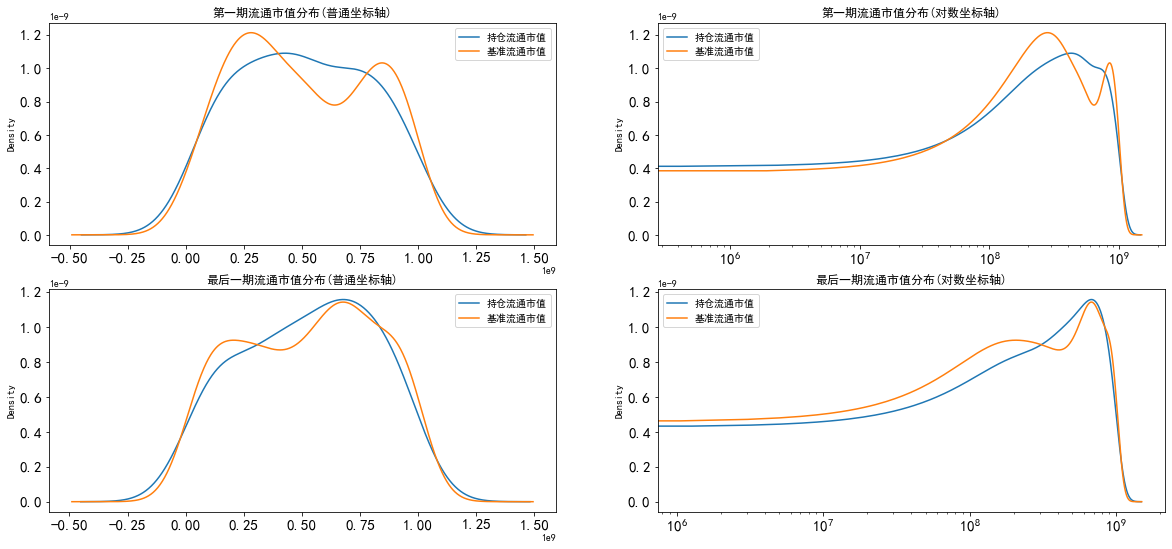

In [21]:
factor_name = '流通市值'

fig=plt.figure(figsize=figsize)
# 第一期
ax1 = fig.add_subplot(221)
df = fab.raw_universe_df_dict[min(fab.raw_universe_df_dict.keys())]
df = df[df[result.group_list[0]] > 0]
first_period_df = pd.concat([df[factor_name],
                              fab.benchmark_weight_df_dict[min(fab.benchmark_weight_df_dict.keys())][factor_name]],
                            axis=1)
first_period_df.columns=('持仓'+factor_name, '基准'+factor_name)
first_period_df['持仓'+factor_name].plot(kind='kde', ax=ax1, fontsize=15) 
first_period_df['基准'+factor_name].plot(kind='kde', ax=ax1, fontsize=15) 
plt.legend()
plt.title('第一期{0}分布(普通坐标轴)'.format(factor_name))

ax2 = fig.add_subplot(222)
df = fab.raw_universe_df_dict[min(fab.raw_universe_df_dict.keys())]
df = df[df[result.group_list[0]] > 0]
first_period_df = pd.concat([df[factor_name],
                              fab.benchmark_weight_df_dict[min(fab.benchmark_weight_df_dict.keys())][factor_name]],
                            axis=1)
first_period_df.columns=('持仓'+factor_name, '基准'+factor_name)
first_period_df['持仓'+factor_name].plot(kind='kde', ax=ax2, logx=True, fontsize=15) 
first_period_df['基准'+factor_name].plot(kind='kde', ax=ax2, logx=True, fontsize=15) 
plt.legend()
plt.title('第一期{0}分布(对数坐标轴)'.format(factor_name))
# 最后一期
ax3 = fig.add_subplot(223)
df = fab.raw_universe_df_dict[max(fab.raw_universe_df_dict.keys())]
df = df[df[result.group_list[0]] > 0]
last_period_df = pd.concat([df[factor_name],
                              fab.benchmark_weight_df_dict[max(fab.benchmark_weight_df_dict.keys())][factor_name]],
                            axis=1)
last_period_df.columns=('持仓'+factor_name, '基准'+factor_name)
last_period_df['持仓'+factor_name].plot(kind='kde', ax=ax3, fontsize=15) 
last_period_df['基准'+factor_name].plot(kind='kde', ax=ax3, fontsize=15) 
plt.legend()
plt.title('最后一期{0}分布(普通坐标轴)'.format(factor_name))

ax4 = fig.add_subplot(224)
df = fab.raw_universe_df_dict[max(fab.raw_universe_df_dict.keys())]
df = df[df[result.group_list[0]] > 0]
last_period_df = pd.concat([df[factor_name],
                              fab.benchmark_weight_df_dict[max(fab.benchmark_weight_df_dict.keys())][factor_name]],
                            axis=1)
last_period_df.columns=('持仓'+factor_name, '基准'+factor_name)
last_period_df['持仓'+factor_name].plot(kind='kde', ax=ax4, logx=True, fontsize=15) 
last_period_df['基准'+factor_name].plot(kind='kde', ax=ax4, logx=True, fontsize=15) 
plt.legend()
plt.title('最后一期{0}分布(对数坐标轴)'.format(factor_name))

## 行业权重分布

Text(0.5, 1.0, '最后一期')

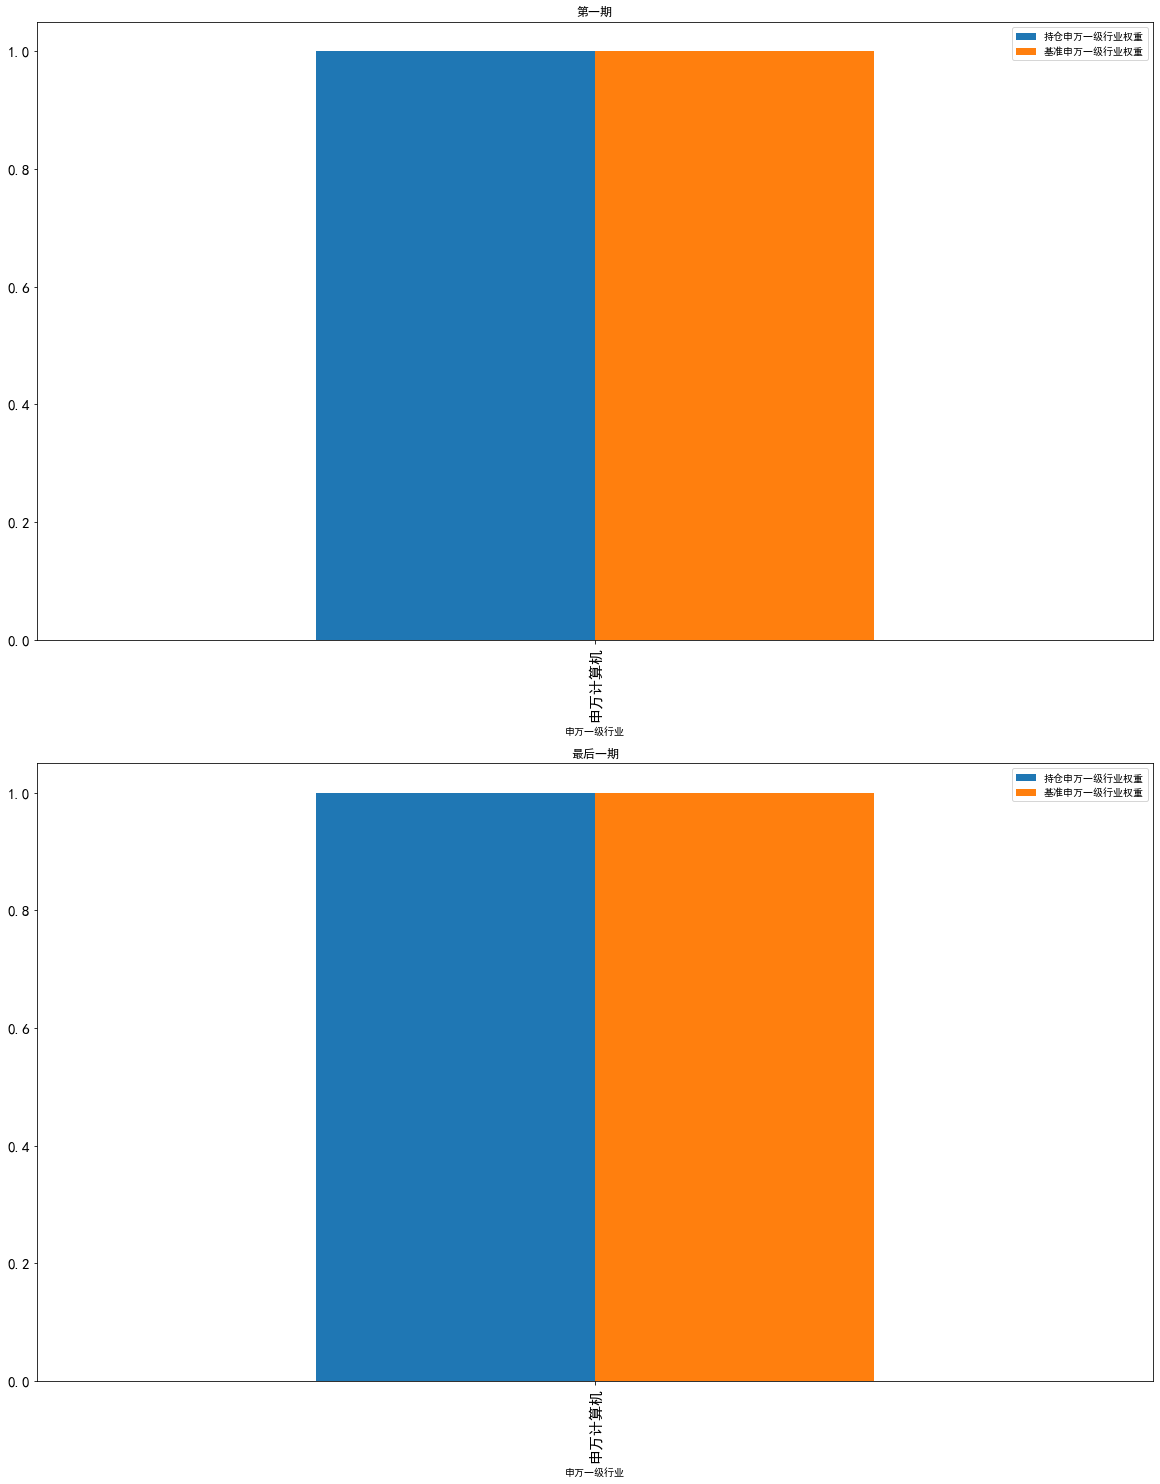

In [22]:
industry_factor_name = '申万一级行业'

fig=plt.figure(figsize=(20,25))
# 第一期
ax1 = fig.add_subplot(211)
df = fab.raw_universe_df_dict[min(fab.raw_universe_df_dict.keys())]
df = df[df[result.group_list[0]] > 0]
bench_df = fab.benchmark_weight_df_dict[min(fab.benchmark_weight_df_dict.keys())]
first_period_df = pd.concat([df.groupby(industry_factor_name)[result.group_list[0]].sum(),
                             bench_df.groupby(industry_factor_name)['权重'].sum()],
                            axis=1)
first_period_df.columns = ('持仓'+industry_factor_name+'权重', '基准'+industry_factor_name+'权重')
first_period_df.sort_values('持仓'+industry_factor_name+'权重',inplace=True, ascending=False)
first_period_df.plot(kind='bar', ax=ax1, fontsize=15)
plt.title('第一期')
# 最后一期
ax1 = fig.add_subplot(212)
df = fab.raw_universe_df_dict[max(fab.raw_universe_df_dict.keys())]
df = df[df[result.group_list[0]] > 0]
bench_df = fab.benchmark_weight_df_dict[max(fab.benchmark_weight_df_dict.keys())]
last_period_df = pd.concat([df.groupby(industry_factor_name)[result.group_list[0]].sum(),
                             bench_df.groupby(industry_factor_name)['权重'].sum()],
                            axis=1)
last_period_df.columns = ('持仓'+industry_factor_name+'权重', '基准'+industry_factor_name+'权重')
last_period_df.sort_values('持仓'+industry_factor_name+'权重',inplace=True, ascending=False)
last_period_df.plot(kind='bar', ax=ax1, fontsize=15)
plt.title('最后一期')